In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import os
import sys
import pickle
from glob import glob

from olympus import Surface
from olympus.campaigns import ParameterSpace, Campaign
from olympus.objects import ParameterContinuous
from olympus.datasets import Dataset
from atlas.planners.gp.planner import GPPlanner
from atlas.unknown_constraints.benchmark_functions import BraninConstr

sns.set(style='ticks', context='notebook', font_scale=1.2)
from cmcrameri import cm


/home/garyk/mambaforge/envs/atlas/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def cummax_with_values(df, key='hypervolume'):
    """
    Performs cumulative maximum on hypervolume column and replaces all other columns
    with values from the rows where each maximum occurred.
    """
    # Create a copy to avoid modifying the original
    cummax_mask = df[key].cummin() == df[key]
    for column in df.columns:
        df[column] = df[column].where(cummax_mask).ffill()
    df[key] = df[key].cummin()
    
    return df

In [3]:
dataset = Dataset(kind='dye_lasers')

planner = GPPlanner(
    goal='minimize', 
    is_moo=True,
    scalarizer_kind='Hypervolume',
    value_space=dataset.value_space,
    goals=['max', 'min', 'max'],
)
planner.set_param_space(dataset.param_space)


───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

In [4]:
# load results from random and gps
res_gp = pickle.load(open('results_moo_gp.pkl', 'rb'))
res_random = pickle.load(open('results_moo_random.pkl', 'rb'))

# compile the results
for i, r in enumerate(res_gp): 
    r['run'] = i
    r['hypervolume'] = planner.scalarizer.scalarize(r[['peak_score', 'spectral_overlap', 'fluo_rate']].to_numpy())
    r = cummax_with_values(r)
for i, r in enumerate(res_random): 
    r['run'] = i
    r['hypervolume'] = planner.scalarizer.scalarize(r[['peak_score', 'spectral_overlap', 'fluo_rate']].to_numpy())
    r = cummax_with_values(r)

res_random = pd.concat(res_random)
res_random['run_type'] = 'RandomSearch'

res_gp = pd.concat(res_gp)
res_gp['run_type'] = 'GPPlanner'

all_results = pd.concat([res_gp, res_random])



In [5]:
all_results.head()

,frag_a,frag_b,frag_c,peak_score,spectral_overlap,fluo_rate,run,hypervolume,run_type
0,OB(O)c1ccc(F)c2ccccc12,C[N+]12CC(=O)O[B-]1(c1cc(I)cc(C(F)(F)F)c1)OC(=...,CC(C)(C)c1ccc2c(Br)c3ccccc3c(Br)c2c1,0.836579,0.490152,0.209032,0.0,0.812609,GPPlanner
1,OB(O)c1cc(Cl)ccc1Cl,C[N+]12CC(=O)O[B-]1(c1ccccc1Br)OC(=O)C2,Fc1c(F)c(Br)c2nsnc2c1Br,0.678858,0.063725,0.098457,0.0,0.792149,GPPlanner
2,OB(O)c1cc(Cl)ccc1Cl,C[N+]12CC(=O)O[B-]1(c1ccccc1Br)OC(=O)C2,Fc1c(F)c(Br)c2nsnc2c1Br,0.678858,0.063725,0.098457,0.0,0.792149,GPPlanner
3,OB(O)c1cc(Cl)ccc1Cl,C[N+]12CC(=O)O[B-]1(c1ccccc1Br)OC(=O)C2,Fc1c(F)c(Br)c2nsnc2c1Br,0.678858,0.063725,0.098457,0.0,0.792149,GPPlanner
4,OB(O)c1cc(Cl)ccc1Cl,C[N+]12CC(=O)O[B-]1(c1ccccc1Br)OC(=O)C2,Fc1c(F)c(Br)c2nsnc2c1Br,0.678858,0.063725,0.098457,0.0,0.792149,GPPlanner


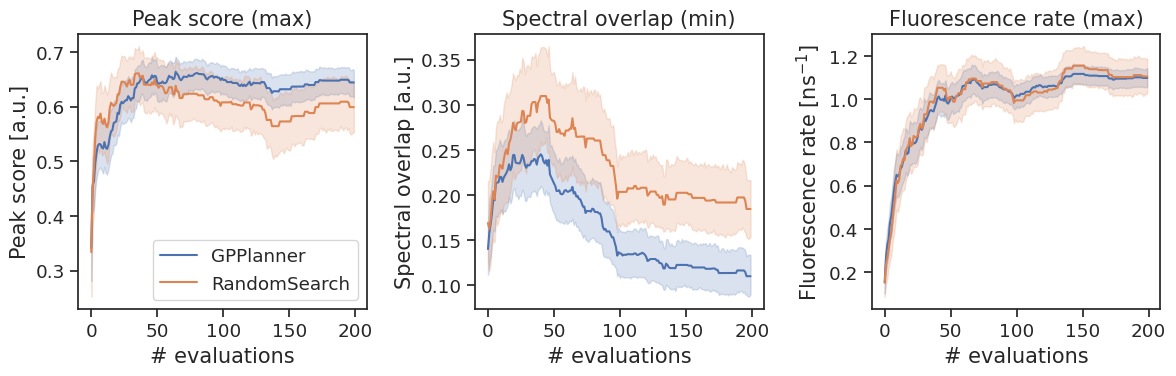

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.lineplot(data=all_results, x=all_results.index, y='peak_score', hue='run_type', ax=axes[0])
axes[0].set_xlabel(r'# evaluations', fontsize=15)
axes[0].set_ylabel(r'Peak score [a.u.]', fontsize=15)
axes[0].set_title('Peak score (max)', fontsize=15)
axes[0].legend(title=None)

sns.lineplot(data=all_results, x=all_results.index, y='spectral_overlap', hue='run_type', ax=axes[1], legend=False)
axes[1].set_xlabel(r'# evaluations', fontsize=15)
axes[1].set_ylabel(r'Spectral overlap [a.u.]', fontsize=15)
axes[1].set_title('Spectral overlap (min)', fontsize=15)

sns.lineplot(data=all_results, x=all_results.index, y='fluo_rate', hue='run_type', ax=axes[2], legend=False)
axes[2].set_xlabel(r'# evaluations', fontsize=15)
axes[2].set_ylabel(r'Fluorescence rate [ns$^{-1}$]', fontsize=15)
axes[2].set_title('Fluorescence rate (max)', fontsize=15)


plt.tight_layout()
plt.savefig('multi_objective_dye_lasers.png', dpi=300)